In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np
import warnings
import sys
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sys.path.insert(0, '../scripts')
from vizualisation import Data_Viz
from cleaning import DataCleaner
from transformation import DataTransformer
from sklearn.ensemble import RandomForestRegressor


In [2]:
warnings.filterwarnings('ignore')
sys.path.insert(0, '../scripts')
dv= Data_Viz()
dc = DataCleaner()
dt = DataTransformer()

In [3]:
# importing datasets
sample_df = pd.read_csv("../data/sample_submission.csv")
store_df = pd.read_csv("../data/store.csv")
test_df = pd.read_csv("../data/test.csv")
train_df = pd.read_csv("../data/train.csv")
features_df = pd.read_csv("../data/features.csv")


In [4]:
features_df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
features_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Holiday,Year,Month,DayOfMonth,WeekOfYear,weekday,month_season,year_season
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0.0,-,0,2015,7,31,31,1,2,2
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",0,2015,7,31,31,1,2,2
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",0,2015,7,31,31,1,2,2
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0.0,-,0,2015,7,31,31,1,2,2
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0.0,-,0,2015,7,31,31,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,2013.0,"Jan,Apr,Jul,Oct",1,2013,1,1,1,1,0,0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,0.0,-,1,2013,1,1,1,1,0,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,0.0,-,1,2013,1,1,1,1,0,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0.0,-,1,2013,1,1,1,1,0,0


In [6]:
#identify catagorical and numerical
dt.catagory(features_df)

Numerical Columns: ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Holiday', 'Year', 'Month', 'DayOfMonth', 'WeekOfYear', 'weekday', 'month_season', 'year_season']
****************
Categorical Columns: ['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']


In [6]:
#stateholiday hav mixed data types so let's change them to string
dc.replace_rows_str(features_df, "StateHoliday")

Index(['0', 'a', 'b', 'c'], dtype='object')

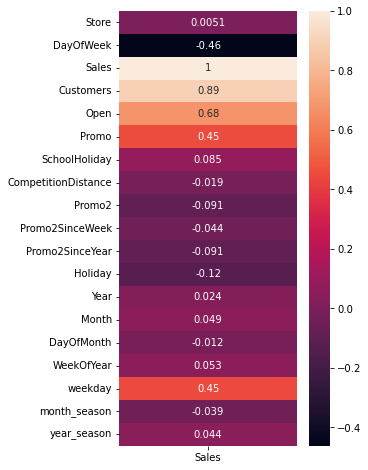

In [7]:
#let's drop some features with least correlation with Sales so we won't have a problem regressing it to our model
import matplotlib.pyplot as plt
import seaborn as sns
lis = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Holiday', 'Year', 'Month', 'DayOfMonth', 'WeekOfYear', 'weekday', 'month_season', 'year_season']
numerical= features_df[lis]
plt.figure(figsize=(4, 8))
sns.heatmap(numerical.corr().loc['Sales',:].to_frame(), annot=True)
plt.show()

In [14]:
lis = ['Sales', 'Customers', 'Date', 'StateHoliday']
feature = features_df[lis]
#i took sample because the size of my model become too big to save
sample_feature = feature.sample(n=100000)

(100000, 4)

In [15]:
#label, scale, spearate target featues, split and the add the steps in pipeline
pipe = Pipeline(steps = [
                        ("labele", FunctionTransformer(dt.cat_labeler, kw_args={"cat_cols": ['Date', 'StateHoliday']})),
                        ("scale", FunctionTransformer(dt.scaler)), 
                        ("target_feature", FunctionTransformer(dt.target_feature, kw_args={"f_r":1, "t":0})),
                        ("split", FunctionTransformer(dt.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8}))
                        ])

P = pipe.fit_transform(sample_feature)

In [16]:
#random forest regressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(P[0], P[1]) 

RandomForestRegressor(random_state=0)

In [17]:
import pickle
filename = "../models/random_forest.pkl"
pickle.dump(regressor, open(filename, 'wb'))

In [18]:
#let's check if the accuracy is affected on the sampled data
Y_pred = regressor.score(P[2], P[3])
Y_pred

0.8418083611056444